<a href="https://colab.research.google.com/github/JF17-EngineerCivInd/JFP_challenge1-data-science-latam/blob/main/AluraStoreLatam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Alura Store LATAM — Informe de Análisis** ##
**Objetivo:** Identificar la tienda menos eficiente para recomendar su venta.  
**Autor:** Jimmy Nicolás Flores Pinto  
**Fecha:** 18-08-2025

---


## **Índice** ##
1. [Metodología](#metodologia)
2. [Datos y preparación](#datos)
3. [Análisis exploratorio](#eda)
   - 3.1. Facturación por tienda
   - 3.2. Ventas por categoría
   - 3.3. Calificación promedio por tienda
   - 3.4. Productos más y menos vendidos
   - 3.5. Costo de envío promedio por tienda
4. [KPIs comparativos y recomendación](#kpis)
5. [Conclusiones](#conclusiones)


## **1. Metodología <a name="metodologia"></a>**
- Unificación de las 4 tiendas en un único DataFrame (`df`) con etiqueta `Tienda`.
- Normalización de tipos (fechas, numéricos) y limpieza de nombres de columnas.
- Métricas por tienda: **Facturación**, **Unidades vendidas**, **Calificación promedio**, **Costo de envío promedio**.
- Visualizaciones interactivas con **Plotly** y tablas de apoyo con **Pandas**.
- Cálculo de un **score compuesto** (Min–Max) con ponderación:
  - Facturación (40%), Calificación (30%), Unidades (20%), Envío (10%).


## **2. Datos y preparación <a name="datos"></a>**
- Fuente: CSVs del repositorio del challenge (Trello/Alura).
- Estructura consolidada en `df` con columna `Tienda` (1 a 4).
- Moneda para *Precio* y *Costo de envío*: **COP (Pesos Colombianos)**.


## **3. Análisis exploratorio <a name="eda"></a>**
A continuación se presentan los análisis solicitados.


### Importación de datos



In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_1%20.csv"
url2 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_2.csv"
url3 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_3.csv"
url4 = "https://raw.githubusercontent.com/alura-es-cursos/challenge1-data-science-latam/refs/heads/main/base-de-datos-challenge1-latam/tienda_4.csv"

tienda1 = pd.read_csv(url)
tienda2 = pd.read_csv(url2)
tienda3 = pd.read_csv(url3)
tienda4 = pd.read_csv(url4)

tienda1.head()

,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon
0,Asistente virtual,Electrónicos,164300.0,6900.0,16/01/2021,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175
1,Mesa de comedor,Muebles,192300.0,8400.0,18/05/2022,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359
2,Juego de mesa,Juguetes,209600.0,15900.0,15/03/2021,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444
3,Microondas,Electrodomésticos,757500.0,41000.0,03/05/2022,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250
4,Silla de oficina,Muebles,335200.0,20200.0,07/11/2020,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359


In [3]:
# === PASO 1: Preparación (unir tiendas y tipificar datos) ===
import pandas as pd

# 1) Detecta cómo se llaman tus dataframes
opciones = [
    ('tienda1','tienda2','tienda3','tienda4'),
    ('tienda_1','tienda_2','tienda_3','tienda_4'),
]
encontrado = False
for a,b,c,d in opciones:
    if all(n in globals() for n in (a,b,c,d)):
        tienda1, tienda2, tienda3, tienda4 = [globals()[n].copy() for n in (a,b,c,d)]
        encontrado = True
        break
if not encontrado:
    raise NameError("No encuentro los DataFrames de tiendas. Ejecuta antes la celda de importación.")

# 2) Etiqueta cada tienda
for i, tdf in enumerate([tienda1, tienda2, tienda3, tienda4], start=1):
    tdf['Tienda'] = f'Tienda {i}'

# 3) Une todo
df = pd.concat([tienda1, tienda2, tienda3, tienda4], ignore_index=True)
df.columns = [c.strip() for c in df.columns]  # limpia espacios en nombres

# 4) Fecha de compra -> datetime (busca la columna por nombre aproximado)
fecha_col = next((c for c in df.columns if c.lower().startswith('fecha') and 'compra' in c.lower()), None)
if fecha_col:
    df[fecha_col] = pd.to_datetime(df[fecha_col], dayfirst=True, errors='coerce')

# 5) Convierte a numérico columnas clave si existen
candidatas_num = ['precio','costo de envío','calificación','cantidad de cuotas','emi','late']
for c in df.columns:
    if any(pal in c.lower() for pal in candidatas_num):
        df[c] = pd.to_numeric(df[c], errors='coerce')

# 6) Vista rápida
print("Filas y columnas:", df.shape)
display(df.head())
display(df.dtypes)


Filas y columnas: (9435, 13)


,Producto,Categoría del Producto,Precio,Costo de envío,Fecha de Compra,Vendedor,Lugar de Compra,Calificación,Método de pago,Cantidad de cuotas,lat,lon,Tienda
0,Asistente virtual,Electrónicos,164300.0,6900.0,2021-01-16,Pedro Gomez,Bogotá,4,Tarjeta de crédito,8,4.60971,-74.08175,Tienda 1
1,Mesa de comedor,Muebles,192300.0,8400.0,2022-05-18,Beatriz Morales,Medellín,1,Tarjeta de crédito,4,6.25184,-75.56359,Tienda 1
2,Juego de mesa,Juguetes,209600.0,15900.0,2021-03-15,Juan Fernandez,Cartagena,1,Tarjeta de crédito,1,10.39972,-75.51444,Tienda 1
3,Microondas,Electrodomésticos,757500.0,41000.0,2022-05-03,Juan Fernandez,Cali,4,Nequi,1,3.43722,-76.52250,Tienda 1
4,Silla de oficina,Muebles,335200.0,20200.0,2020-11-07,Maria Alfonso,Medellín,5,Nequi,1,6.25184,-75.56359,Tienda 1


,0
Producto,object
Categoría del Producto,object
Precio,float64
Costo de envío,float64
Fecha de Compra,datetime64[ns]
Vendedor,object
Lugar de Compra,object
Calificación,int64
Método de pago,object
Cantidad de cuotas,int64


## **Template Base** ##

In [4]:
# === TEMPLATE UTILIDADES + GRÁFICOS (Plotly) ===
# Deja este bloque en una sola celda al inicio del notebook.
import pandas as pd
import plotly.express as px

# ⚙️ Parámetros globales (puedes cambiarlos)
MONEDA = "COP (Pesos Colombianos)"  # etiqueta por defecto para montos
ANCHO, ALTO = 680, 420              # tamaño por defecto de gráficos
BWIDTH = 0.4                        # grosor por defecto de las barras

# -------------------- AGRUPAMIENTOS RÁPIDOS --------------------
def group_sum(df, by, value_col):
    """Suma value_col por claves 'by' (string o lista). Útil para facturación/costos."""
    g = df.groupby(by, dropna=False)[value_col].sum().reset_index()
    return g.sort_values(value_col, ascending=False)

def group_mean(df, by, value_col):
    """Promedio de value_col por claves 'by'. Útil para calificaciones, tiempos, etc."""
    g = df.groupby(by, dropna=False)[value_col].mean().reset_index()
    return g.sort_values(value_col, ascending=False)

def group_count(df, by, count_col='Producto'):
    """Conteo por claves 'by'. Útil para # de ventas, # de productos, etc."""
    g = df.groupby(by, dropna=False)[count_col].count().reset_index(name='Conteo')
    return g.sort_values('Conteo', ascending=False)

# -------------------- ESCALA Y FORMATOS (MONETARIO) --------------------
def _scale_and_formats(series, en_millones=True, etiqueta_moneda=MONEDA):
    """
    Escala serie (millones o valor completo) y devuelve:
    - serie escalada
    - etiqueta Y
    - formato de ticks
    - plantilla de hover
    """
    if en_millones:
        s = series / 1_000_000
        ylabel  = f"Millones de {etiqueta_moneda}"
        tickfmt = ',.2f'
        hover   = '<b>%{x}</b><br>Valor: %{y:,.2f} MM<extra></extra>'
    else:
        s = series
        ylabel  = etiqueta_moneda
        tickfmt = ',.0f'
        hover   = '<b>%{x}</b><br>Valor: %{y:,.0f}<extra></extra>'
    return s, ylabel, tickfmt, hover

# -------------------- GRÁFICOS: BARRAS (SIMPLE) --------------------
def plot_bar(df_plot, x, y, titulo, ylabel=None, color=None,
             en_millones=False, ancho=ANCHO, alto=ALTO, barwidth=BWIDTH, centrar_titulo=True):
    """
    Barra simple (una métrica por categoría).
    - en_millones=True solo si 'y' es monetario (facturación, costo, etc.)
    - color: columna para colorear (ej: 'Tienda') o None
    """
    data_y = df_plot[y]
    if ylabel is None and en_millones:  # monetario → formateo especial
        data_y, ylabel, tickfmt, hover = _scale_and_formats(data_y, True)
        df_plot = df_plot.copy(); df_plot[y] = data_y
    elif ylabel is None:
        ylabel, tickfmt = y, ',.0f'
        hover = '<b>%{x}</b><br>Valor: %{y:,.0f}<extra></extra>'

    fig = px.bar(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: ylabel})
    fig.update_traces(hovertemplate=hover, width=barwidth)
    fig.update_layout(
        width=ancho, height=alto,
        yaxis=dict(tickformat=tickfmt, showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        margin=dict(l=40, r=20, t=50, b=40),
        title={'x':0.5} if centrar_titulo else None
    )
    fig.show()

# -------------------- GRÁFICOS: BARRAS (AGRUPADAS / APILADAS) --------------------
def plot_bar_multi(df_plot, x, y, color, titulo, modo='group',
                   ylabel=None, en_millones=False, ancho=ANCHO, alto=ALTO, barwidth=BWIDTH):
    """
    Barras con varias series (por ejemplo, categorías por tienda).
    - modo='group' (agrupadas) o 'stack' (apiladas)
    - en_millones=True solo si 'y' es monetario
    """
    data_y = df_plot[y]
    if ylabel is None and en_millones:
        data_y, ylabel, tickfmt, hover = _scale_and_formats(data_y, True)
        df_plot = df_plot.copy(); df_plot[y] = data_y
    elif ylabel is None:
        ylabel, tickfmt = y, ',.0f'
        hover = '<b>%{x}</b><br>%{fullData.name}: %{y:,.0f}<extra></extra>'

    fig = px.bar(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: ylabel})
    fig.update_traces(hovertemplate=hover, width=barwidth)
    fig.update_layout(
        width=ancho, height=alto, barmode=('stack' if modo=='stack' else 'group'),
        yaxis=dict(tickformat=tickfmt, showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        margin=dict(l=40, r=20, t=50, b=40),
        title={'x':0.5}
    )
    fig.show()

# -------------------- GRÁFICO: ROSCA / PIE --------------------
def plot_pie(df_plot, names, values, titulo):
    """Proporciones (ej: participación por categoría)."""
    fig = px.pie(df_plot, names=names, values=values, title=titulo, hole=0.3)
    fig.update_traces(textinfo='percent+label',
                      hovertemplate='<b>%{label}</b><br>Valor: %{value}<extra></extra>')
    fig.update_layout(title={'x':0.5}, width=ANCHO, height=ALTO)
    fig.show()

# -------------------- GRÁFICO: BOXPLOT --------------------
def plot_box(df, x, y, titulo, color=None):
    """Distribución y dispersión (ej: calificación por tienda)."""
    fig = px.box(df, x=x, y=y, color=color, title=titulo, points="all")
    fig.update_layout(width=ANCHO, height=ALTO, title={'x':0.5})
    fig.show()

# -------------------- GRÁFICO: LÍNEA --------------------
def plot_line(df_plot, x, y, titulo, color=None, ylabel=None):
    """Tendencia en el tiempo (ej: ventas por fecha)."""
    fig = px.line(df_plot, x=x, y=y, color=color, title=titulo, labels={x:'', y: (ylabel or y)})
    fig.update_layout(width=ANCHO, height=ALTO, title={'x':0.5})
    fig.show()


# -------------------- Suite para grafico 3.2 --------------------
def plot_cat_lines(g_cat, cat_col, top_n=None, width=820, height=480):
    """
    Línea única con 4 tiendas (una línea por tienda) vs categorías en el eje X.
    - g_cat: DataFrame con columnas ['Tienda', cat_col, 'Conteo'] (sale de group_count).
    - top_n: si pones un número, limita a las categorías más vendidas (evita amontonamiento).
    """
    # Orden global de categorías por volumen total
    order = (g_cat.groupby(cat_col)['Conteo'].sum()
             .sort_values(ascending=False).index.tolist())
    if top_n:
        order = order[:top_n]

    gc = g_cat[g_cat[cat_col].isin(order)].copy()
    gc[cat_col] = pd.Categorical(gc[cat_col], categories=order, ordered=True)

    fig = px.line(
        gc.sort_values(cat_col),
        x=cat_col, y='Conteo', color='Tienda', markers=True,
        title='Ventas por categoría — perfil por tienda',
        labels={cat_col:'Categoría', 'Conteo':'Unidades', 'Tienda':''}
    )
    fig.update_traces(line=dict(width=2))
    fig.update_layout(
        width=width, height=height,
        xaxis=dict(showline=True, linewidth=1, tickangle=-20,
                   categoryorder='array', categoryarray=order),
        yaxis=dict(showline=True, linewidth=1),
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5,
                    itemclick='toggle', itemdoubleclick='toggleothers'),
        margin=dict(l=40, r=20, t=60, b=70),
        title={'x':0.5}
    )
    fig.show()


# -------------------- Suite para grafico 3.3 --------------------
# Línea simple. Usa PALETTE_TIENDAS si x == 'Tienda'
def plot_line_simple(df_, x, y, title, y_range=None, width=820, height=480):
    import pandas as pd, plotly.express as px
    d = df_.copy()
    if x == 'Tienda':  # orden Tienda 1..4
        orden = sorted(d[x].unique(), key=lambda t: int(str(t).split()[-1]))
        d[x] = pd.Categorical(d[x], categories=orden, ordered=True)
    fig = px.line(
        d.sort_values(x), x=x, y=y,
        color=(x if x=='Tienda' else None), markers=True,
        color_discrete_map=(PALETTE_TIENDAS if x=='Tienda' else None),
        title=title, labels={x:'', y:y}
    )
    fig.update_traces(line=dict(width=3), hovertemplate='%{x}<br>%{y:.2f}<extra></extra>')
    fig.update_layout(
        width=width, height=height,
        yaxis=dict(range=y_range, dtick=(1 if y_range==[0,5] else None), showline=True, linewidth=1),
        xaxis=dict(showline=True, linewidth=1),
        legend=dict(orientation='h', yanchor='bottom', y=-0.25, xanchor='center', x=0.5,
                    itemclick='toggle', itemdoubleclick='toggleothers'),
        margin=dict(l=40, r=20, t=60, b=70), title={'x':0.5}
    )
    fig.show()


#3.1. Análisis de facturación



In [5]:
# FACTURACIÓN POR TIENDA (tabla)
precio_col = next(c for c in df.columns if 'precio' in c.lower())
g_fact = group_sum(df, by='Tienda', value_col=precio_col)
display(g_fact.round(0))


,Tienda,Precio
0,Tienda 1,1.150880e+09
1,Tienda 2,1.116344e+09
2,Tienda 3,1.098020e+09
3,Tienda 4,1.038376e+09


In [6]:
# FACTURACIÓN POR TIENDA (gráfico interactivo)
plot_bar(g_fact, x='Tienda', y=precio_col,
         titulo='Facturación por tienda',
         color='Tienda', en_millones=True)


# 3.2. Ventas por categoría

In [7]:
# VENTAS POR CATEGORÍA (tabla)
cat_col = next(c for c in df.columns if 'categor' in c.lower())
prod_col = next(c for c in df.columns if 'producto' in c.lower())

g_cat = group_count(df, by=['Tienda', cat_col], count_col=prod_col)
display(g_cat.head(10))

pivot_cat = g_cat.pivot(index=cat_col, columns='Tienda', values='Conteo').fillna(0).astype(int)
display(pivot_cat)


,Tienda,Categoría del Producto,Conteo
23,Tienda 3,Muebles,499
31,Tienda 4,Muebles,480
7,Tienda 1,Muebles,465
27,Tienda 4,Electrónicos,451
19,Tienda 3,Electrónicos,451
3,Tienda 1,Electrónicos,448
15,Tienda 2,Muebles,442
11,Tienda 2,Electrónicos,422
29,Tienda 4,Juguetes,338
5,Tienda 1,Juguetes,324


Tienda,Tienda 1,Tienda 2,Tienda 3,Tienda 4
Categoría del Producto,,,,
Artículos para el hogar,171,181,177,201
Deportes y diversión,284,275,277,277
Electrodomésticos,312,305,278,254
Electrónicos,448,422,451,451
Instrumentos musicales,182,224,177,170
Juguetes,324,313,315,338
Libros,173,197,185,187
Muebles,465,442,499,480


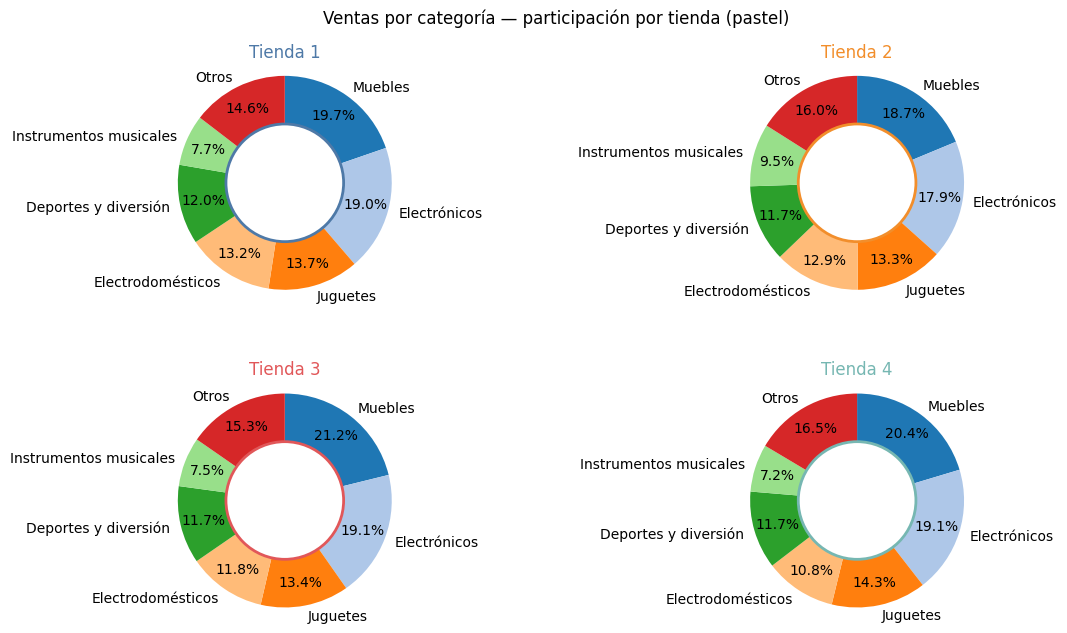

In [8]:
# 3.2 — Ventas por categoría
import matplotlib.pyplot as plt

# --- columnas ---
cat_col  = next(c for c in df.columns if 'categor' in c.lower())
prod_col = next(c for c in df.columns if 'producto' in c.lower())

# --- conteos Tienda x Categoría ---
pivot = df.groupby(['Tienda', cat_col])[prod_col].count().unstack(fill_value=0)

# orden global y TOP_N
orden_global = pivot.sum(axis=0).sort_values(ascending=False)
TOP_N = 6
cats_top = list(orden_global.index[:TOP_N])
otros = pivot.drop(columns=cats_top).sum(axis=1)

pivot_top = pivot[cats_top].copy()
if (pivot.shape[1] - TOP_N) > 0:
    pivot_top['Otros'] = otros

# colores de tienda (como 3.1)
PALETTE_TIENDAS = {
    'Tienda 1': '#4E79A7',
    'Tienda 2': '#F28E2B',
    'Tienda 3': '#E15759',
    'Tienda 4': '#76B7B2',
}
# colores por categoría (consistentes en los 4 pies)
cmap = plt.get_cmap('tab20')
cats = pivot_top.columns.tolist()
COL_CAT = {c: cmap(i % 20) for i, c in enumerate(cats)}

# --- más espacio horizontal entre subplots ---
fig, axes = plt.subplots(
    2, 2, figsize=(12, 7),                # un poco más ancho
    gridspec_kw={'wspace': 0.60, 'hspace': 0.35}   # <-- separaciones
)
axes = axes.ravel()

for ax, tienda in zip(axes, sorted(pivot_top.index)):
    vals = pivot_top.loc[tienda].values
    labels = pivot_top.columns.tolist()
    colors = [COL_CAT[c] for c in labels]

    wedges, texts, autotexts = ax.pie(
        vals, labels=labels, colors=colors,
        autopct=lambda p: f'{p:.1f}%' if p >= 3 else '',
        startangle=90, counterclock=False, pctdistance=0.78
    )
    aro = plt.Circle((0, 0), 0.55, fc='white',
                     edgecolor=PALETTE_TIENDAS.get(tienda, 'gray'), lw=2)
    ax.add_artist(aro)
    ax.set_title(tienda, color=PALETTE_TIENDAS.get(tienda, 'black'))
    ax.axis('equal')

fig.suptitle('Ventas por categoría — participación por tienda (pastel)', y=0.98)
# aseguramos que la separación se mantenga
fig.subplots_adjust(wspace=0.60, hspace=0.35, top=0.90)
plt.show()


# 3.3. Calificación promedio de la tienda


In [9]:
# CALIFICACIÓN PROMEDIO POR TIENDA (tabla)
calif_col = next(c for c in df.columns if 'calificación' in c.lower())
g_calif = group_mean(df, by='Tienda', value_col=calif_col)
display(g_calif.round(2))


,Tienda,Calificación
2,Tienda 3,4.05
1,Tienda 2,4.04
3,Tienda 4,4.00
0,Tienda 1,3.98


In [10]:
# CALIFICACIÓN PROMEDIO POR TIENDA (gráfico con rango fijo)
import plotly.express as px

fig = px.bar(g_calif,
             x='Tienda', y=calif_col, color='Tienda',
             title='Calificación promedio por tienda',
             labels={'Tienda':'', calif_col:'Calificación promedio'})
fig.update_traces(width=0.4)
fig.update_layout(
    width=680, height=420,
    yaxis=dict(range=[0,5], dtick=1, showline=True, linewidth=1),
    xaxis=dict(showline=True, linewidth=1),
    margin=dict(l=40, r=20, t=50, b=40),
    title={'x':0.5}
)
fig.show()



# 3.4. Productos más y menos vendidos

In [11]:
# PRODUCTOS MÁS Y MENOS VENDIDOS — Tablas por tienda
prod_col = next(c for c in df.columns if 'producto' in c.lower())
g_prod = group_count(df, by=['Tienda', prod_col], count_col=prod_col)

top5 = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, False])
              .groupby('Tienda', group_keys=False).head(5))

bottom5 = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, True])
                 .groupby('Tienda', group_keys=False).head(5))

print("🔝 TOP 5 productos por tienda")
display(top5)

print("\n🔻 BOTTOM 5 productos por tienda")
display(bottom5)


🔝 TOP 5 productos por tienda


,Tienda,Producto,Conteo
48,Tienda 1,TV LED UHD 4K,60
33,Tienda 1,Microondas,60
1,Tienda 1,Armario,60
40,Tienda 1,Secadora de ropa,58
32,Tienda 1,Mesa de noche,56
75,Tienda 2,Iniciando en programación,65
84,Tienda 2,Microondas,62
58,Tienda 2,Batería,61
89,Tienda 2,Pandereta,58
72,Tienda 2,Guitarra acústica,58



🔻 BOTTOM 5 productos por tienda


,Tienda,Producto,Conteo
13,Tienda 1,Celular ABXY,33
4,Tienda 1,Auriculares con micrófono,33
37,Tienda 1,Olla de presión,35
38,Tienda 1,Pandereta,36
34,Tienda 1,Mochila,39
77,Tienda 2,Juego de mesa,32
74,Tienda 2,Impresora,34
82,Tienda 2,Mesa de comedor,34
95,Tienda 2,Sillón,35
54,Tienda 2,Auriculares,37


In [17]:
# 3.4 — Top 5 productos más vendidos por tienda (orden ↓, más espacio)
from plotly.subplots import make_subplots
import plotly.graph_objects as go

prod_col = next(c for c in df.columns if 'producto' in c.lower())

# Conteo y top-5 por tienda
g_prod = group_count(df, by=['Tienda', prod_col], count_col=prod_col)
top5   = (g_prod.sort_values(['Tienda','Conteo'], ascending=[True, False])
                .groupby('Tienda', group_keys=False).head(5))

orden_t = sorted(top5['Tienda'].unique(), key=lambda t: int(str(t).split()[-1]))

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=orden_t,
    horizontal_spacing=0.20,    # ← más espacio entre columnas
    vertical_spacing=0.16
)

for i, t in enumerate(orden_t):
    r, c = i//2 + 1, i%2 + 1
    dfi = top5[top5['Tienda']==t].sort_values('Conteo', ascending=False)  # mayor→menor

    fig.add_bar(
        x=dfi['Conteo'], y=dfi[prod_col], orientation='h',
        marker_color=PALETTE_TIENDAS.get(t, '#6e6e6e'),
        text=dfi['Conteo'], textposition='outside', cliponaxis=False,
        width=0.85,  # barras un poquito más gruesas
        row=r, col=c
    )

    # Orden de categorías y que el primero aparezca ARRIBA
    fig.update_yaxes(
        categoryorder='array',
        categoryarray=dfi[prod_col].tolist(),
        autorange='reversed',
        showline=True, linewidth=1,
        row=r, col=c
    )
    fig.update_xaxes(showline=True, linewidth=1, row=r, col=c)

fig.update_layout(
    title={'text':'Top 5 productos más vendidos por tienda', 'x':0.5, 'y':0.98},
    width=1100, height=720, bargap=0.15,
    margin=dict(l=100, r=20, t=100, b=50),   # ← mayor separación del título
    showlegend=False
)

fig.show()


# 3.5. Envío promedio por tienda

In [13]:
# COSTO DE ENVÍO PROMEDIO POR TIENDA — tabla
envio_col = next(c for c in df.columns if ('costo' in c.lower()) and ('env' in c.lower()))
g_envio = group_mean(df, by='Tienda', value_col=envio_col)
display(g_envio.round(0))


,Tienda,Costo de envío
0,Tienda 1,26019.0
1,Tienda 2,25216.0
2,Tienda 3,24806.0
3,Tienda 4,23459.0


In [14]:
# COSTO DE ENVÍO PROMEDIO POR TIENDA — gráfico
plot_bar(g_envio, x='Tienda', y=envio_col,
         titulo='Costo de envío promedio por tienda',
         color='Tienda', en_millones=True)


## **4. KPIs comparativos y recomendación <a name="kpis"></a>**
Resumen de desempeño por tienda y **score** compuesto para priorizar la decisión de venta.


In [15]:
# === RESUMEN DE KPIs + RECOMENDACIÓN FINAL ===
import pandas as pd
import numpy as np
from IPython.display import Markdown, display

precio_col = next(c for c in df.columns if 'precio' in c.lower())
calif_col  = next(c for c in df.columns if 'calif'  in c.lower())
envio_col  = next(c for c in df.columns if ('costo' in c.lower() and 'env' in c.lower()))
prod_col   = next(c for c in df.columns if 'producto' in c.lower())

kpis = pd.DataFrame({
    'Facturación': df.groupby('Tienda')[precio_col].sum(),
    'Calificación_prom': df.groupby('Tienda')[calif_col].mean(),
    'Envío_prom': df.groupby('Tienda')[envio_col].mean(),
    'Unidades': df.groupby('Tienda')[prod_col].count()
})

def minmax(s):
    mn, mx = s.min(), s.max()
    return (s - mn) / (mx - mn) if mx > mn else pd.Series(0.5, index=s.index)

w_fact, w_calif, w_unid, w_env = 0.40, 0.30, 0.20, 0.10

kpis['fact_norm']  = minmax(kpis['Facturación'])
kpis['calif_norm'] = minmax(kpis['Calificación_prom'])
kpis['unid_norm']  = minmax(kpis['Unidades'])
kpis['env_norm']   = 1 - minmax(kpis['Envío_prom'])  # menor costo = mejor

kpis['Score'] = (w_fact*kpis['fact_norm'] +
                 w_calif*kpis['calif_norm'] +
                 w_unid*kpis['unid_norm'] +
                 w_env*kpis['env_norm'])

kpis_orden = kpis.sort_values('Score', ascending=False).round(3)
tienda_menos_ef = kpis_orden.index[-1]
tienda_mejor    = kpis_orden.index[0]

display(kpis_orden[['Facturación','Calificación_prom','Envío_prom','Unidades','Score']])

row = kpis.loc[tienda_menos_ef]
def qual(val, serie, alto_mejor=True):
    mn, mx = serie.min(), serie.max()
    if mx == mn: return "similar al resto"
    terc1, terc2 = mn + (mx-mn)/3, mn + 2*(mx-mn)/3
    if alto_mejor:
        return "alto" if val >= terc2 else ("bajo" if val <= terc1 else "medio")
    else:
        return "bajo (mejor)" if val <= terc1 else ("alto (peor)" if val >= terc2 else "medio")

md = f"""
**Recomendación:** Vender **{tienda_menos_ef}**.

**Resumen de {tienda_menos_ef}:**
- Facturación: {qual(row['Facturación'], kpis['Facturación'], True)}
- Unidades vendidas: {qual(row['Unidades'], kpis['Unidades'], True)}
- Calificación promedio: {qual(row['Calificación_prom'], kpis['Calificación_prom'], True)}
- Costo de envío promedio: {qual(row['Envío_prom'], kpis['Envío_prom'], False)}

**Mejor desempeño general:** {tienda_mejor} (score más alto).
"""
display(Markdown(md))


,Facturación,Calificación_prom,Envío_prom,Unidades,Score
Tienda,,,,,
Tienda 2,1.116344e+09,4.037,25216.236,2359,0.762
Tienda 3,1.098020e+09,4.048,24805.680,2359,0.759
Tienda 1,1.150880e+09,3.977,26018.610,2359,0.600
Tienda 4,1.038376e+09,3.996,23459.457,2358,0.180



**Recomendación:** Vender **Tienda 4**.

**Resumen de Tienda 4:**
- Facturación: bajo
- Unidades vendidas: bajo
- Calificación promedio: bajo
- Costo de envío promedio: bajo (mejor)

**Mejor desempeño general:** Tienda 2 (score más alto).


## 5. Conclusiones

- **Tienda recomendada para vender:** **Tienda 4**.
- **Fundamentos (posición dentro de 4 tiendas, 1=mejor):**
  - **Facturación:** 1.038.38 MM COP (**4/4**).
  - **Unidades vendidas:** 2.358 (**4/4**).
  - **Calificación promedio:** 4.00 (**3/4**).
  - **Costo de envío promedio:** 0.02 MM COP (**1/4**, *menor es mejor*).
- **Mejor desempeño general:** **Tienda 2** (score más alto).

> **Nota:**

  El *score* compuesto pondera
  - Facturación (40%)
  - Calificación (30%)
  - Unidades (20%)
  - Envío (10%).
